In [69]:
#Author: Simon Zhu
#Date: 7.14.2020

# Preprocessing the Data

### 1. Read the files and join corresponding datasets

In [31]:
# import the necessary packages
import pandas as pd
import numpy as np

# read the files and create datasets
df_id = pd.read_csv("newtrain_identity.csv", index_col = "TransactionID")
df_trans = pd.read_csv("newtrain_transaction_200000.csv", index_col = "TransactionID")
df_id_test = pd.read_csv("newtest_identity.csv",index_col = "TransactionID")
df_trans_test = pd.read_csv("newtest_transaction_withoutlabel.csv",index_col = "TransactionID")

In [33]:
print(df_id.shape,df_trans.shape,df_id_test.shape,df_trans_test.shape)

(134233, 40) (80397, 393) (10000, 40) (10000, 392)


In [34]:
#df_train_new = df_trans
#df_test = df_trans_test
df_train = df_trans.merge(df_id, how='left', left_index=True, right_index=True)
df_test = df_trans_test.merge(df_id_test, how='left', left_index=True, right_index=True)

In [35]:
print(df_train.shape,df_test.shape)

(80397, 433) (10000, 432)


### 2. Remove the outliers WRT Transaction Amount

In [36]:
# As demonstrated in the EDA notebook, outliers only comprise 1.74% of the fraud data, 
# so removing the outliers may give a more accurate distribution of the fraud data
data_mean, data_std = np.mean(df_train['TransactionAmt']), np.std(df_train['TransactionAmt'])
cut = 3* data_std # anything lying three stds or more away from the mean are considered outliers
# remove the outliers from the original dataset and create a new one
df_train = df_train[(df_train['TransactionAmt']>data_mean-cut) & (df_train['TransactionAmt']<data_mean+cut)]
print(df_train.shape)

(79049, 433)


### 3. Drop the labels from the training dataset

In [37]:
# separate the labels from the training data
df_train_no_label = df_train.drop('isFraud',axis=1)
df_train_label = df_train[['isFraud']].copy()
df_test_no_label = df_test.copy()
print(df_train_no_label.shape,df_test_no_label.shape)

(79049, 432) (10000, 432)


### 4. Feature selection

In [38]:
# import the necessary packages
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

In [39]:
# drop unnecessary categorical data based on findings in the EDA notebook
# drop all NaN columns
df_train_no_label.drop(['P_emaildomain', 'R_emaildomain','M1','M2',"M3", 'M4','M5','M6','M7','M8','M9'], axis = 1,inplace=True)
df_test_no_label.drop(['P_emaildomain', 'R_emaildomain','M1','M2',"M3", 'M4','M5','M6','M7','M8','M9'], axis = 1,inplace=True)

for col in df_test_no_label.columns:
    if df_test_no_label[col].isnull().values.any():
        df_train_no_label[col].dropna(how='all',inplace=True)
        df_test_no_label[col].dropna(how='all',inplace=True)

In [40]:
print(df_train_no_label.shape,df_test_no_label.shape)

(79049, 421) (10000, 421)


### 5. Encode the categorical features

In [42]:
def label_encoding(X_train, cat_idx, X_test):
    for f in cat_idx:
        cat_encoder = LabelEncoder()
        cat_encoder.fit(list(X_train[f].values) + list(X_test[f].values))
        X_train[f] = cat_encoder.transform(list(X_train[f].values))
        X_test[f] = cat_encoder.transform(list(X_test[f].values))
    return X_train, X_test

In [43]:
cat_idx = df_train_no_label.select_dtypes(include=['category',object]).columns
df_train_no_label,df_test_no_label = label_encoding(df_train_no_label, cat_idx, df_test_no_label)

In [44]:
print(df_train_no_label.shape,df_test_no_label.shape)

(79049, 421) (10000, 421)


# Building the Model

In [16]:
import xgboost as xgb
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score

In [70]:
xgb_clf = xgb.XGBClassifier()
AUROCs = cross_validate(xgb_clf, df_train_no_label, df_train_label.values.ravel(), scoring="roc_auc",
                    cv=5, return_train_score=False)

In [397]:
print(AUROCs['test_score'])
print("mean",np.mean(AUROCs['test_score']))

[0.85548457 0.85698026 0.84170096 0.89975663 0.78250281]
mean 0.847285047797515


### Use RandomizedSearchCV to tune hyperparameters

In [18]:
from scipy import stats
from sklearn.model_selection import RandomizedSearchCV

xgb_clf_new = xgb.XGBClassifier(objective = 'binary:logistic')
param_dist = {'n_estimators': stats.randint(200, 1000),
              'learning_rate': stats.uniform(0.01, 0.5),
              'subsample': stats.uniform(0.3, 0.7),
              'max_depth': [3, 4, 5, 6, 7, 8, 9],
              'colsample_bytree': stats.uniform(0.5, 0.5),
              'min_child_weight': [1, 2, 3, 4]
             }

clf = RandomizedSearchCV(xgb_clf_new, 
                         param_distributions = param_dist,
                         cv = 5,
                         n_iter = 5,  
                         scoring = 'roc_auc',  
                         verbose = 1)

In [19]:
clf.fit(df_train_no_label, df_train_label.values.ravel())

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 46.3min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
       colsample_bynode=None, colsample_bytree=None, gamma=None,
       gpu_id=None, importance_type='gain', interaction_constraints=None,
       learning_rate=None, max_delta_step=None, max_depth=None,
       min_child_w..._pos_weight=None, subsample=None,
       tree_method=None, validate_parameters=None, verbosity=None),
          fit_params=None, iid='warn', n_iter=5, n_jobs=None,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fbe6a4da048>, 'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fbe6a4da1d0>, 'subsample': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fbe6a4da748>, 'max_depth': [3, 4, 5, 6, 7, 8, 9], 'colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fbe6a4da5c0>, 'min_child_weight': [1, 2, 3, 4]},
         

In [24]:
# The AUROC score of the best estimator found by the RandomizedSearchCV
print(clf.best_score_)

0.8976827314137139


**The AUROC score of the model is 89.77%**

In [25]:
#save the model
import pickle
filename = 'finalized_model.sav'
pickle.dump(clf, open(filename, 'wb'))

# Interpretation of the model

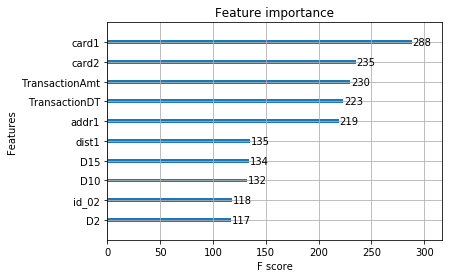

In [29]:
# plot feature importance using built-in function
from numpy import loadtxt
from xgboost import plot_importance
from matplotlib import pyplot
%matplotlib inline
# plot feature importance
plot_importance(clf.best_estimator_,max_num_features=10)
pyplot.show()
# It turns out that card1, card2, TransactionAmt, TransactionDT, addr 1
# are the Top 5 features that can decide whether a transaction is fraud or not.

# Use the model for prediction

In [66]:
# load the model from disk
filename = 'finalized_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.predict_proba(df_test_no_label)
print(result)

[[9.9976236e-01 2.3766156e-04]
 [9.9854243e-01 1.4575502e-03]
 [9.9895185e-01 1.0481552e-03]
 ...
 [9.9795496e-01 2.0450533e-03]
 [9.7163826e-01 2.8361753e-02]
 [9.9959499e-01 4.0502593e-04]]


In [67]:
# read and revise the test file
newsample_submission = pd.read_csv('newsample_submission.csv', index_col = 'TransactionID')
newsample_submission['isFraud'] = result[:,[1]]
#print(newsample_submission)
newsample_submission.to_csv('simple_xgboost.csv')

In [68]:
#sanity check
np.mean(newsample_submission)

isFraud    0.056351
dtype: float32

# Reflection and Takeaways

### 1. Explanation of the exploration process

1. During the first trial, I used lightgbm rather than xgboost, and chose OneHot Encoding to encode every categorical feature, the final AUROC result is 77.21%. Considering that the lightgbm algorithm handles the missing values pretty well, I continue to play around with the features to see whether manipulation can result in higher AUROC score.

2. Therefore, during my second trial, I dropped all the columns with missing values, leaving us only about 60 columns. Ceteris paribus, the corresponding AUROC score dropped to 72.34%. This trial indicates that there are many features with missing values that are still significant. Therefore, a complete elimination of missing-value features does not improve the model.

3. Realizing that, what I did next is to see the power of the categorical data. Therefore, I dropped all categorical data in the next run, and realize that the AUROC score became 73.3%, significantly lower than the first trial. It makes me realize that there are definitely some important catgorical features.

4. Thus, in the next trial, I referred back to the EDA notebook, and pick out the features that do not have significant impact on the percentage of "fraud". About 9 features were dropped.


### 2. Lessons Learned & Questions for Future Exploration

1. Surprisingly, OneHot Encoding and Label Encoding can yield drastly different results. In our case, OneHot Encoding actually leads to lower accuracy for lightgbm algorithm. I dig into this issue, and realize that OneHot Encoding prevents the problem caused by distance bias between the values, but it also increases number of features, thereby may disturbing performance of lightgbm model. --> Tips for future exploration: Find out which categorical features are ordinal. If they are ordinal, use LabelEncoder; otherwise, use OneHot Encoder.

2. Some other thoughts on PCA: The example code uses PCA and significantly increases the accuracy of the model. Yet when I use PCA, it reduces the AUROC to 68%. Since the only difference between my code and the example code is that I did not drop as many columns, I wonder whether the inputs to PCA will significantly affect the final accuracy.

3. ALWAYS SAVE THE MODEL. It will be a diaster if you have to refit the model every time you restart the program.

4. RandomizedSearchCV can be our friend. The hyperparameter tuning process, although time-consuming, indeed enhances the performance of the model. The mean AUROC score increases from 84.7% to 89%.

### 3. AUROC

**The mean AUROC score for validation of the model is 89.77%** (Please refer to previous sections for specific codes)